**3장 – 분류**

_이 노트북은 3장의 모든 샘플 코드와 연습 문제 정답을 담고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/03_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [4]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# 폴더 생성
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [11]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [12]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [13]:
y.shape

(70000,)

그림 저장: some_digit_plot


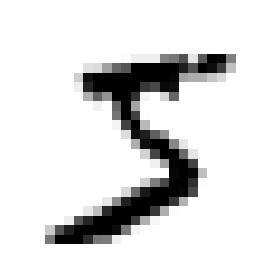

In [19]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [20]:
y[0]

5

In [21]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [22]:
y = y.astype(np.uint8)

In [23]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [24]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: more_digits_plot


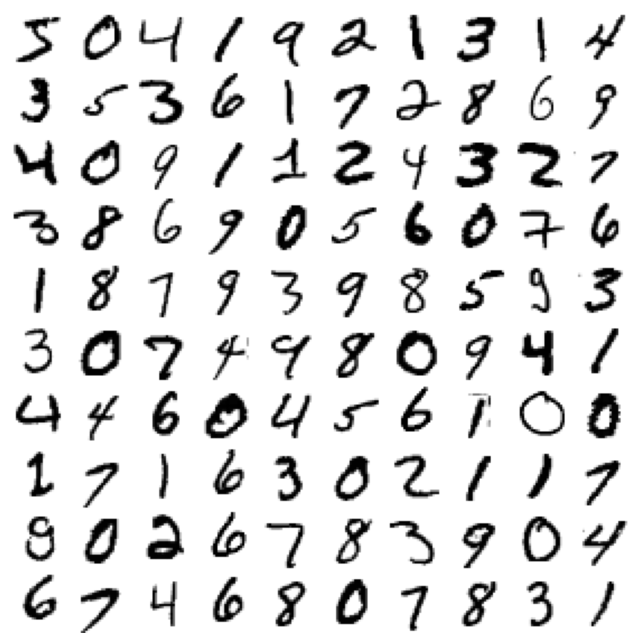

In [18]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [25]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# 60000으로 끊어도 되는 이유, 이미 데이터가 shuffle이 되어있기 때문에




# 이진 분류기

In [26]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [31]:
# y_train_5 에는 어떤 값이 들어가잇냐
# 5면 true, 5가 아니면 false
y_train_5

array([ True, False, False, ...,  True, False, False])

**노트**: `max_iter`와 `tol` 같은 일부 매개변수는 사이킷런 다음 버전에서 기본값이 바뀝니다. 버전이 업데이트되더라도 결과가 바뀌지 않도록 아예 나중에 바뀔 기본값을 사용해 명시적으로 지정하겠습니다. 번거로움을 피하기 위해 책에는 따로 표시하지 않았습니다.

In [29]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

In [30]:
# max_iter : 최대 학습횟수
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
# sgd_clf. 에서 찾아보면 iteration이 몇번까지 돌아갔는지 확인할 수 있는 메서드가 있음

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    
    
# cross_val_score 을 안쓰고 이걸 쓰는 이유.
# 각각의 폴드의 검증결과를 볼수있고, 검증결과가 낮은 폴드는 그 폴드에 대해 오류를 분석할 수 있음

0.9669
0.91625
0.96785


In [33]:
sgd_clf.predict([some_digit])

array([ True])

# 교차검증

In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
# unblance 테이터는 정확도로 평가하면 안되고 혼동행렬과 fl score로 평가를 해야함

In [36]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [44]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

In [39]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [41]:
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [42]:
y_train_perfect_predictions = y_train_5  # 완변한척 하자
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [46]:
# 정밀도와 재현율
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [48]:
cm = confusion_matrix(y_train_5,y_train_pred)
cm[1,1] / (cm[0,1]+cm[1,1])



0.8370879772350012

In [49]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [50]:
cm[1,1] / (cm[1,0]+cm[1,1])

0.6511713705958311

In [51]:
# fl_score
f1_score(y_train_5,y_train_pred)

# fl score 가 73정도로 낮은 값이면 다른 모델을 써야하는 방법으로 가야함

0.7325171197343846

In [52]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

# 정밀도/재현율 트레이드 오프

In [54]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [55]:
threshold =0
y_some_digit_pred =y_scores>threshold

In [56]:
y_some_digit_pred

array([ True])

In [57]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [58]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")


In [59]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

그림 저장: precision_recall_vs_threshold_plot


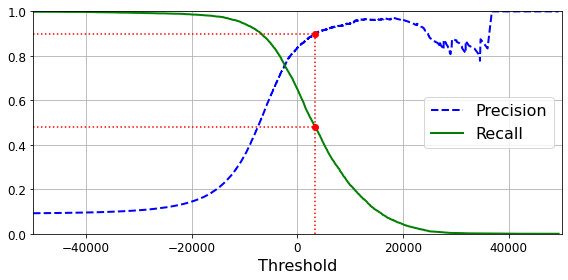

In [60]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [61]:
(y_train_pred == (y_scores > 0)).all()

True

그림 저장: precision_vs_recall_plot


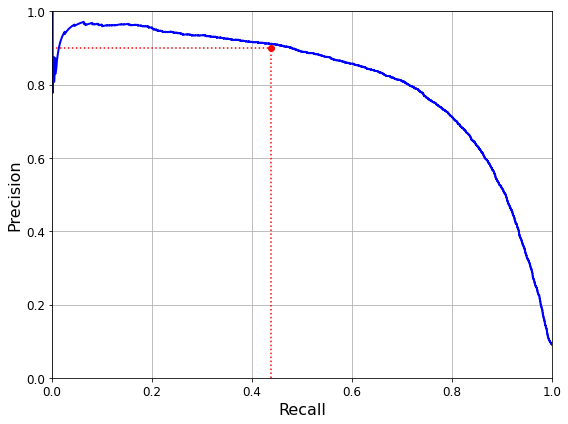

In [62]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [63]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# ROC 곡선

In [64]:
from sklearn.metrics import roc_curve

In [66]:
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

그림 저장: roc_curve_plot


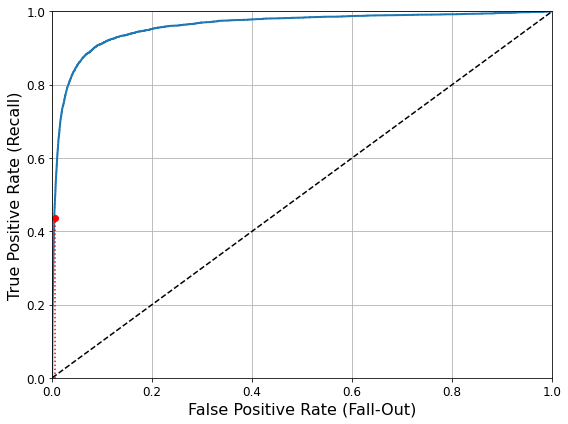

In [67]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [69]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9604938554008616

**노트**: 사이킷런 0.22 버전에서 바뀔 기본 값을 사용해 `n_estimators=100`로 지정합니다.

# 랜덤포레스트 모델 사용

In [70]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')


In [71]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [73]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >=  4.837e-3)]

그림 저장: roc_curve_comparison_plot


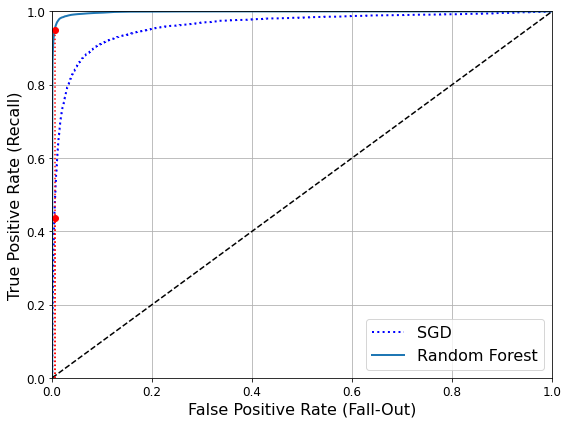

In [74]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

# 다중 분류

In [76]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

In [77]:
svm_clf = SVC(gamma='auto',random_state=42)
svm_clf.fit(X_train[:1000],y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [78]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [79]:
np.argmax(some_digit_scores)

5

In [80]:
svm_clf.classes_


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [81]:
svm_clf.classes_[5]
# 5가 의미하는건 인덱스 번호상 5

5

# OVR

ovr은 타깃 레이블의 개수 만큼 로지스틱 회귀 모델을 만들어 각 레이블을 
타깃으로 하는 분류기를 학습시킴.

In [82]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [83]:
len(ovr_clf.estimators_)


10

In [84]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [85]:
sgd_clf.decision_function([some_digit])


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

# 에러분석

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

KeyboardInterrupt: 

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [65]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

그림 저장: confusion_matrix_plot


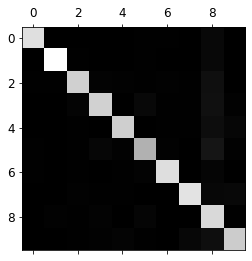

In [66]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [67]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

그림 저장: confusion_matrix_errors_plot


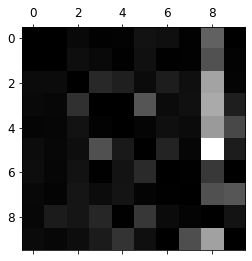

In [68]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

그림 저장: error_analysis_digits_plot


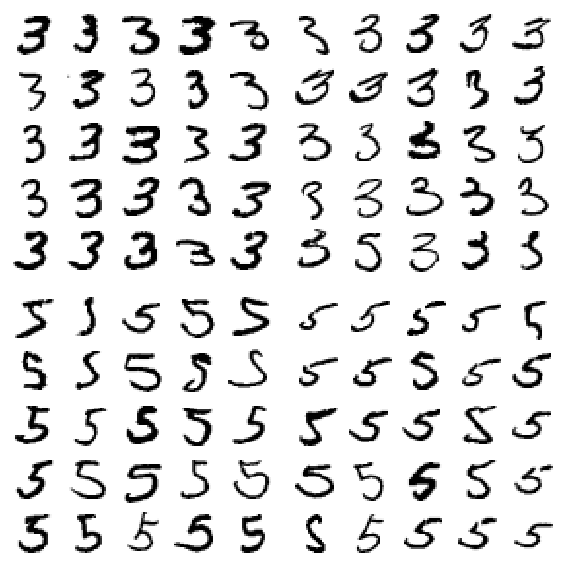

In [69]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# 다중 레이블 분류

다중 레이블 분류는 현업에서 잘쓰이지않음

근데 시험문제에서 분류문제는 타겟값이 하나만 될수있는게 아니라
다중값이 될 수 도있음

In [70]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])


In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 다중 출력 분류

데이터 증강(어그멘테이션) / 

증강시크는 방법들 : 이미지에 노이즈를 줄 수 있음 ( 흐리게 하거나, 색을 짙게해주거나)

데이터를 증강시켜서 모델을 학습할 수 있음




In [73]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

그림 저장: noisy_digit_example_plot


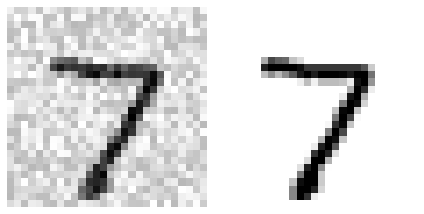

In [74]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()